Imports
====

In [44]:
import numpy as np
from numpy.random import rand, randint
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import heapq
from skimage.draw import line

Functions
====

Grid
---

In [45]:
def can_connect(a,b,grid,occ):
        connection = line(a[0], a[1], b[0], b[1])  
        if np.any(grid[connection] == occ):
            return False

        return True

def init_grid(nodes,eg,occ,n,ip,max_conn,can_connect,am=True):
    graph=np.eye(n)*ip
    graph[graph == 0] = np.inf

    for i in range(n):
        for j in range(n):
            if (j!=i and can_connect(nodes[i,:],nodes[j,:],eg,occ)):
                a = np.atleast_2d(nodes[i,:])
                b = np.atleast_2d(nodes[j,:])
                graph[i,j]=np.linalg.norm(a - b, axis=1) if am else ip


        idx = np.argpartition(graph[i,:], max_conn)
        graph[i,idx[max_conn:]] = np.inf

    graph[graph==np.inf]=0
    return graph

Deterministic Optimal Algorithms
---

In [65]:
class PriorityQueue:
    """
      Implements a priority queue data structure. Each inserted item
      has a priority associated with it and the client is usually interested
      in quick retrieval of the lowest-priority item in the queue. This
      data structure allows O(1) access to the lowest-priority item.
    """
    def  __init__(self):
        self.heap = []
        self.count = 0

    def push(self, item, priority):
        entry = (priority, self.count, item)
        heapq.heappush(self.heap, entry)
        self.count += 1

    def pop(self):
        (_, _, item) = heapq.heappop(self.heap)
        return item

    def isEmpty(self):
        return len(self.heap) == 0

    def update(self, item, priority):
        # If item already in priority queue with higher priority, update its priority and rebuild the heap.
        # If item already in priority queue with equal or lower priority, do nothing.
        # If item not in priority queue, do the same thing as self.push.
        for index, (p, c, i) in enumerate(self.heap):
            if i == item:
                if p <= priority:
                    break
                del self.heap[index]
                self.heap.append((priority, c, item))
                heapq.heapify(self.heap)
                break
        else:
            self.push(item, priority)
            
            
def dijkstra(graph, start, goal):
    node=[start,0]

    front=PriorityQueue()
    front.push(node,0)

    dead=[]

    while front:
        node=front.pop()
        current=int(node[0])
        n_cost=node[-1]

        dead.append(current)

        if current==goal:
            cost=node[-1]
            node.remove(cost)
            path=node[::-1]
            return np.asarray(path),cost
        
        childs=np.nonzero(graph[current,:])[0]
        for child in childs:
            child=int(child)
            c_cost=graph[current,child] #child node cost [from parent node]
            cost=n_cost+c_cost #cumlative path cost
            child_node= [child] + node[:-1] + [cost]

            if child not in dead:
                front.update(child_node,cost)
                

def astar(graph, start, goal, heuristic="Euclidean"):
    node=[start,0]

    front=PriorityQueue()
    front.push(node,0)

    dead=[]

    while front:
        node=front.pop()
        current=int(node[0])
        n_cost=node[-1]

        dead.append(current)

        if current==goal:
            cost=node[-1]
            node.remove(cost)
            path=node[::-1]
            return np.asarray(path),cost
        
        childs=np.nonzero(graph[current,:])[0]
        for child in childs:
            child=int(child)
            c_cost=graph[current,child] #child node cost [from parent node]
            cost=n_cost+c_cost #cumlative path cost, g(n), backward cost
            a = np.atleast_2d(nodes[child,:])
            b = np.atleast_2d(nodes[goal,:])
            h= np.linalg.norm(a - b, axis=1) #estimated path cost, h(n), forward cost
            f=cost+h #evaluation function, f(n)
            child_node= [child] + node[:-1] + [cost]

            if child not in dead:
                front.update(child_node,f)
                
def dp_optimal_cost(G, c, I, costs, policy):
    if I < 0:
        return 0
    N = len(G)
    
    # Cost already calculated
    if costs[c,I] != np.inf:
        return costs[c,I]
        
    for n in range(N):
        # No path to this node
        if G[c,n] == 0 or c == n:
            continue
        
        # Recursion step
        J = G[c,n] + dp_optimal_cost(G, n, I - 1, costs, policy)
        
        # Update minimum cost
        if J > 0 and J < costs[c,I]:
            costs[c,I] = J
            policy[c] = n
    
    return costs[c,I]

def dp(graph, start, goal):
    N = len(graph)
    costs = np.ones((N, N)) * np.inf
    costs[goal,:] = 0
    policy = np.ones((N, 1)) * np.nan
    
    for n in range(N):
        costs[n,N-1]=dp_optimal_cost(graph, n, N - 1, costs, policy)
        
    path = []
    break_condition = 0
    path_found = True   
    
    idx = start
    while idx != goal:
        path.append(idx)
        idx = int(policy[idx])
        break_condition += 1
        
        if break_condition > N:
            path_found = False
            break
        
    if path_found:
        path.append(goal)
    else:
        path = []

    return path,costs[start,goal] 

ACO
---

In [47]:
def RW(pop,prob,r):
    cum_prob=np.cumsum(prob)
    idx=np.where(cum_prob>rand())[0][0]
    return r[idx]

def ant_sol(grid,nodes,alpha,beta,start,end,m,n,select):
    s=[]; L=np.zeros(m);
    for k in range(m):
        i=start; sol=[];
        while(i!=end):
            a=nodes[i,:]
            r=np.nonzero(grid[i,:])[0]
            r=np.asarray([e for e in r if e!=i])
            b=nodes[r,:]
            eta=1/np.linalg.norm(a - b, axis=1); tao=grid[i,r];
            p=((tao**alpha)*(eta**beta))/sum((tao**alpha)*(eta**beta))
            p=p[np.nonzero(p)[0]]
            idx=select(nodes[r,:],p,r)
            sol.append((i,idx))
            i=idx
        L[k]=len(sol)
        s.append(sol)
    
    return s,L

def update_phermones(grid,s,L,Q,rho,m,n):
    for i in range(n):
        for j in range(n):
            if (i!=j and grid[i,j]!=0):
                delta=[Q/L[k] if ([item for item in s[k] if (item[0]==i and item[1]==j)]!=[]) else 0 for k in range(m)]
                grid[i,j]=(1-rho)*grid[i,j]+sum(delta)
    return grid

def get_path(s,L,tao):
    path_aco=s[np.argmin(L)]
    path_aco=[i[0] for i in path_aco]+[path_aco[-1][-1]]
    
    cost=[tao[path_aco[i],path_aco[i+1]] for i in range(len(path_aco)-1)]  
    cost_aco=sum(cost)
    
    return path_aco,cost_aco

Parameters
====

In [69]:
np.random.seed(20)

#Grid Parameters
occ=100
max_conn=10
sz=10
ip=0.1

#Path
start=8
end=60

#ACO
rho=0.8
alpha=1
beta=1
Q=1
m=50
T=20

Implementation
====

Grid Construction
---

In [70]:
#Initialize Empty Grid
eg=np.zeros((sz,sz))

#Defining Obstacles
eg[1,7:10]=occ; eg[2,7:9]=occ; eg[3,1:4]=occ;
eg[3:8,5]=occ; eg[4,1]=occ; eg[7,1:4]=occ;
eg[6:9,8]=occ; eg[6,7]=occ;

#Defining Nodes (Discretization)
idx=np.where(eg!=occ)
n=idx[0].shape[0]
nodes=[[idx[0][i],idx[1][i]] for i in range(len(idx[0]))]
nodes=np.asarray(nodes)

#Initialize Grid
grid=init_grid(nodes,eg,occ,n,ip,max_conn,can_connect)

Dijkstra
---

In [50]:
path_dij,cost_dij=dijkstra(grid,start,end)
path=nodes[path_dij]

A*
---

In [61]:
path_as,cost_as=astar(grid,start,end)
path1=nodes[path_as]

Dynamic Programming
---

In [66]:
path_dp,cost_dp=dp(grid,start,end)
path3=nodes[path_dp]

ACO
---

In [71]:
tao=grid
for t in range(T):
    s,L=ant_sol(tao,nodes,alpha,beta,start,end,m,n,RW)
    tao=update_phermones(tao,s,L,Q,rho,m,n)

path_aco,cost_aco=get_path(s,L,grid)
path2=nodes[path_aco]

Results
====

In [72]:
print("Dijkstra Path = ", path_dij)
print("Dijkstra Path Total Cost = ", cost_dij)
print("A* Path = ", path_as)
print("A* Path Total Cost = ", cost_as)
print("DP Path = ", path_dp)
print("DP Path Total Cost = ", cost_dp)
print("ACO Path = ", path_aco)
print("ACO Path Total Cost = ", cost_aco)

Dijkstra Path =  [ 8  7 16 22 26 33 41 49 55 60]
Dijkstra Path Total Cost =  11.899494936611667
A* Path =  [ 8  7 16 22 26 33 41 49 55 60]
A* Path Total Cost =  11.899494936611667
DP Path =  [8, 7, 22, 26, 33, 41, 49, 55, 60]
DP Path Total Cost =  11.899494936611665
ACO Path =  [8, 7, 6, 16, 15, 22, 21, 26, 33, 32, 41, 49, 48, 55, 60]
ACO Path Total Cost =  24.6059263564315


Plots
===

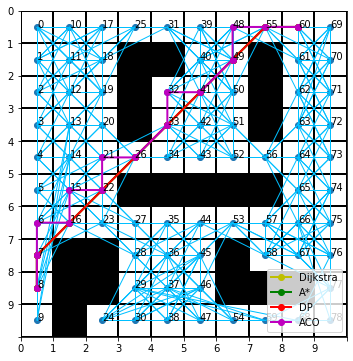

In [73]:
plt.figure(figsize=(6,6))

#Grid
plt.imshow(eg.T,cmap=plt.cm.Greys)
ax=plt.gca()
ax.grid(color='k', linestyle='-', linewidth=2)
ax.set_xticks(np.arange(-0.5, 10, 1))
ax.set_yticks(np.arange(-0.5, 10, 1))
ax.set_xticklabels(np.arange(0,10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))

#Nodes
plt.scatter(idx[0],idx[1])
for node, coord in enumerate(nodes):
    plt.text(coord[0], coord[1], str(node))
    
#Connections
source, sink = np.nonzero(grid)
source=nodes[source,:]
sink=nodes[sink,:]
lc = LineCollection(np.stack((source, sink), axis=1),linewidths=[1], colors=[(0, 0.75, 1, 1)])
ax.add_collection(lc)

#Paths
ax.plot(path[:, 0], path[:, 1], 'yo-', linewidth=4,label='Dijkstra')
ax.plot(path1[:, 0], path1[:, 1], 'go-', linewidth=3,label='A*')
ax.plot(path3[:, 0], path3[:, 1], 'ro-', linewidth=2,label='DP')
ax.plot(path2[:, 0], path2[:, 1], 'mo-', linewidth=1,label='ACO')


plt.legend()
plt.show()